Чернобаев Андрей Александрович М8О-114М-23

# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [1]:
import os

if not os.path.exists('petfaces'):
    !wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
    !tar xfz petfaces.tar.gz
    !rm petfaces.tar.gz

Для визуализации списка изображений можно использовать такую функцию:

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Сколько классов

In [3]:
dataset_folder = 'petfaces'

number_classes = len(os.listdir(dataset_folder))
print("Количество классов:", number_classes)
     

Количество классов: 35


Посмотрим на сбалансированность классов

In [4]:
def calculate_class_balance_tf(dataset_folder):
    class_counts = {}
    
    for subdir, dirs, files in os.walk(dataset_folder):
        for dir in dirs:
            full_dir_path = os.path.join(dataset_folder, dir)
            files_count = len([name for name in os.listdir(full_dir_path) if os.path.isfile(os.path.join(full_dir_path, name))])
            class_counts[dir] = files_count
    
    total_files = sum(class_counts.values())
    class_balance = {cls: count / total_files for cls, count in class_counts.items()}
    
    return class_counts, class_balance

In [5]:
class_counts, class_balance = calculate_class_balance_tf(dataset_folder)
print("Class Counts:", class_counts)
print("Class Balance:", class_balance)

Class Counts: {'dog_great': 91, 'dog_chihuahua': 83, 'cat_British': 100, 'dog_yorkshire': 81, 'cat_Abyssinian': 92, 'cat_Siamese': 100, 'dog_leonberger': 95, 'dog_havanese': 93, 'dog_boxer': 85, 'dog_samoyed': 68, 'cat_Bengal': 74, 'dog_japanese': 74, 'dog_staffordshire': 87, 'cat_Persian': 94, 'dog_saint': 90, 'cat_Russian': 97, 'cat_Maine': 95, 'cat_Ragdoll': 96, 'dog_american': 174, 'dog_beagle': 78, 'dog_german': 69, 'dog_scottish': 59, 'dog_pug': 89, 'dog_english': 182, 'dog_pomeranian': 90, 'dog_newfoundland': 98, 'dog_basset': 88, 'cat_Egyptian': 73, 'dog_keeshond': 83, 'dog_shiba': 82, 'cat_Bombay': 87, 'dog_miniature': 75, 'cat_Sphynx': 100, 'dog_wheaten': 91, 'cat_Birman': 98}
Class Balance: {'dog_great': 0.02834008097165992, 'dog_chihuahua': 0.025848645281843663, 'cat_British': 0.031142946122703206, 'dog_yorkshire': 0.025225786359389598, 'cat_Abyssinian': 0.02865151043288695, 'cat_Siamese': 0.031142946122703206, 'dog_leonberger': 0.029585798816568046, 'dog_havanese': 0.02896

Размер картинок

In [6]:
image_size = 128
batch_size = 64

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as tr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sn

Меняем изображения:

1) изменяем размер
2) обрезаем
3) преобразуем в тензоры

In [8]:
dataset = torchvision.datasets.ImageFolder(
    dataset_folder,
    transform = tr.Compose([
        tr.Resize(image_size), # Меняем все картинки на картинки с одним размером
        tr.CenterCrop(image_size), # Обрезает изображение по центру
        tr.ToTensor() # Преобразует картинки в тензоры, причём с нормализацией
    ]))

pet_classes_names = dataset.classes

Разделим данные на тренировочную и тестовую выборки

In [9]:
len_dataset = len(dataset)
train_length = int(0.8 * len_dataset)
test_length = len_dataset - train_length
split_size = [train_length, test_length]

train_data, test_data = torch.utils.data.random_split(dataset, split_size)

Посмотрим на данные

In [10]:
print('shape and class')
print(train_data[0][0].shape, train_data[0][1])

shape and class
torch.Size([3, 128, 128]) 4


Зададим размер батча и перемешаем данные

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Примеры из датасета

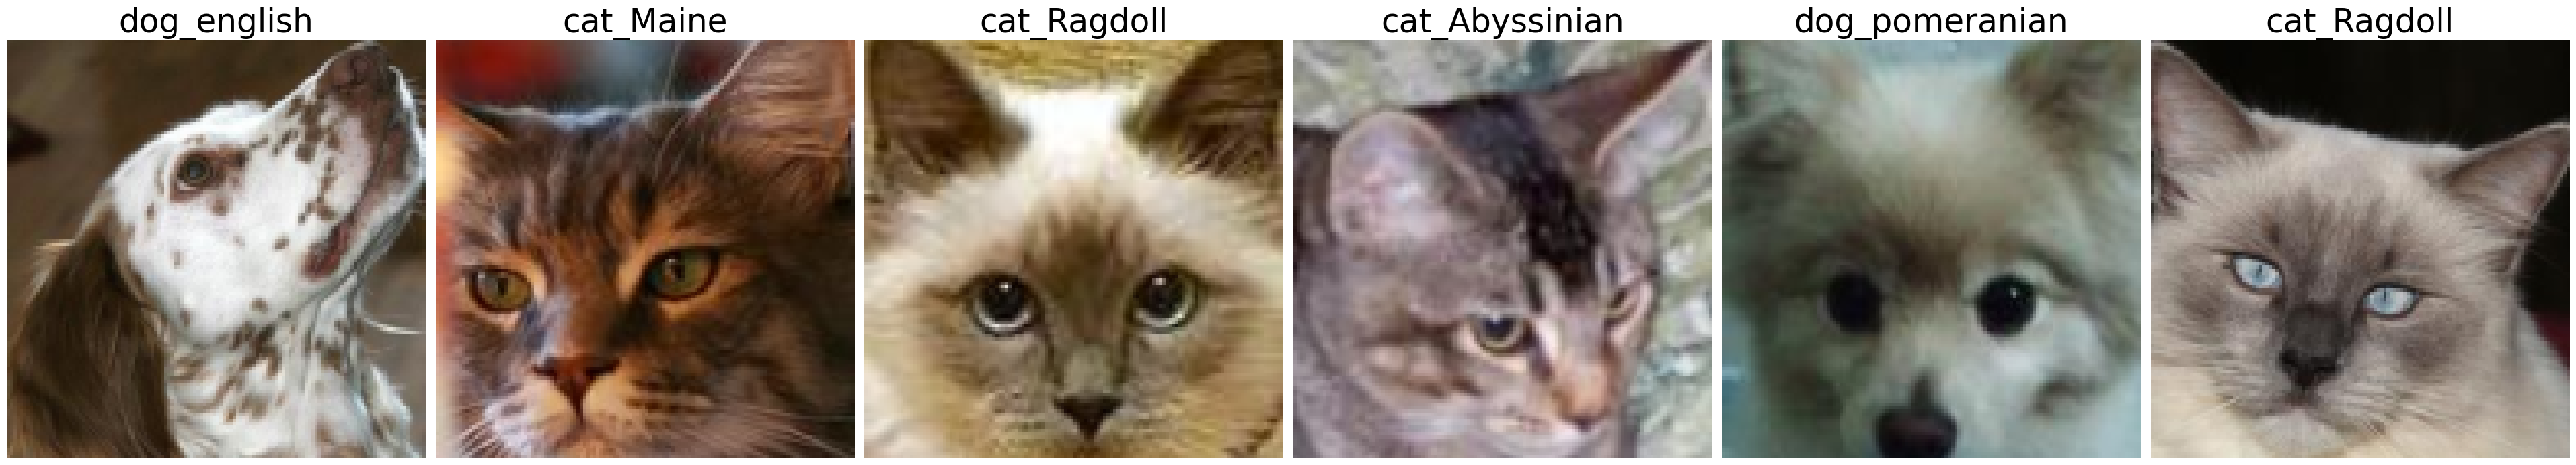

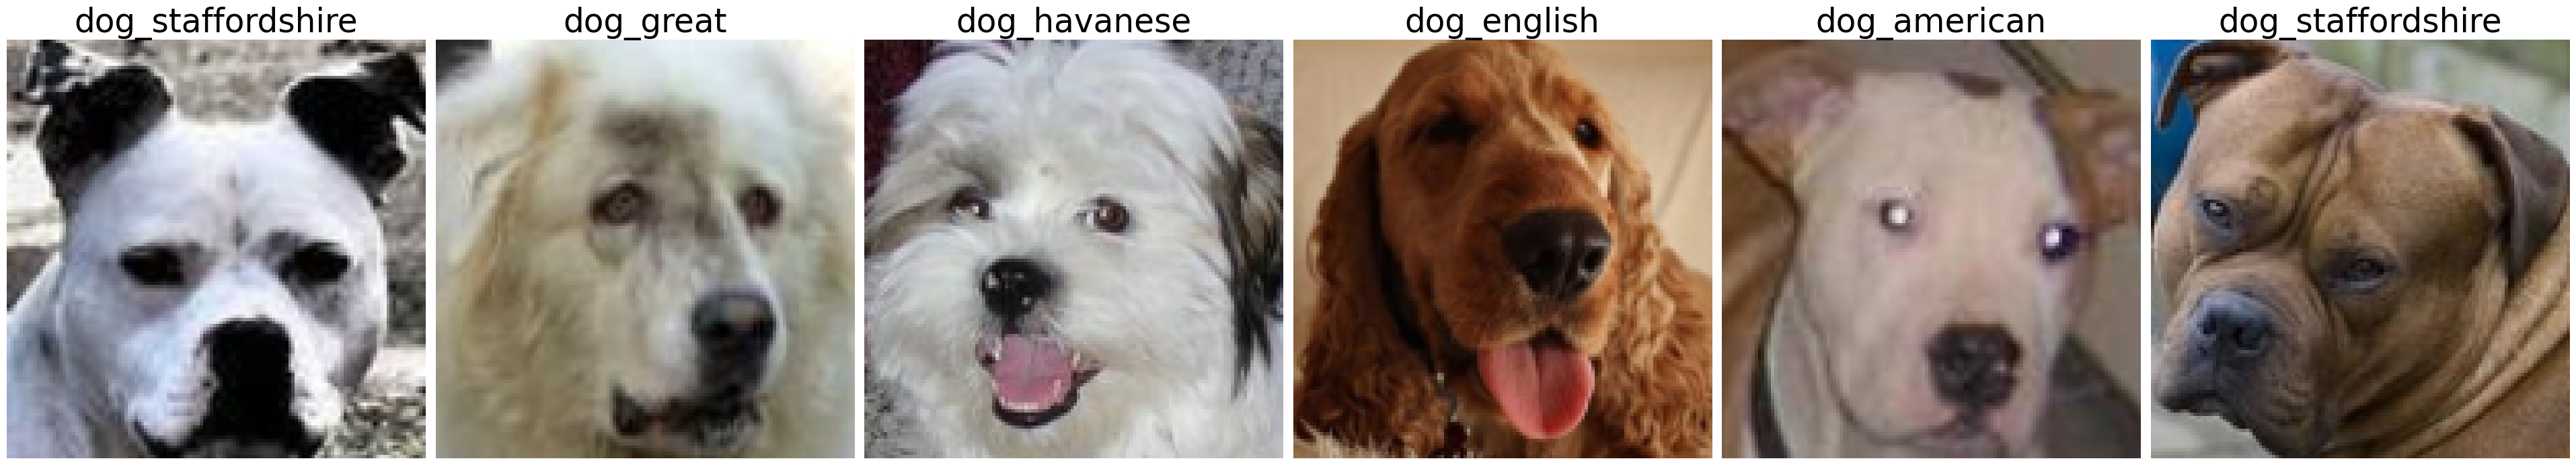

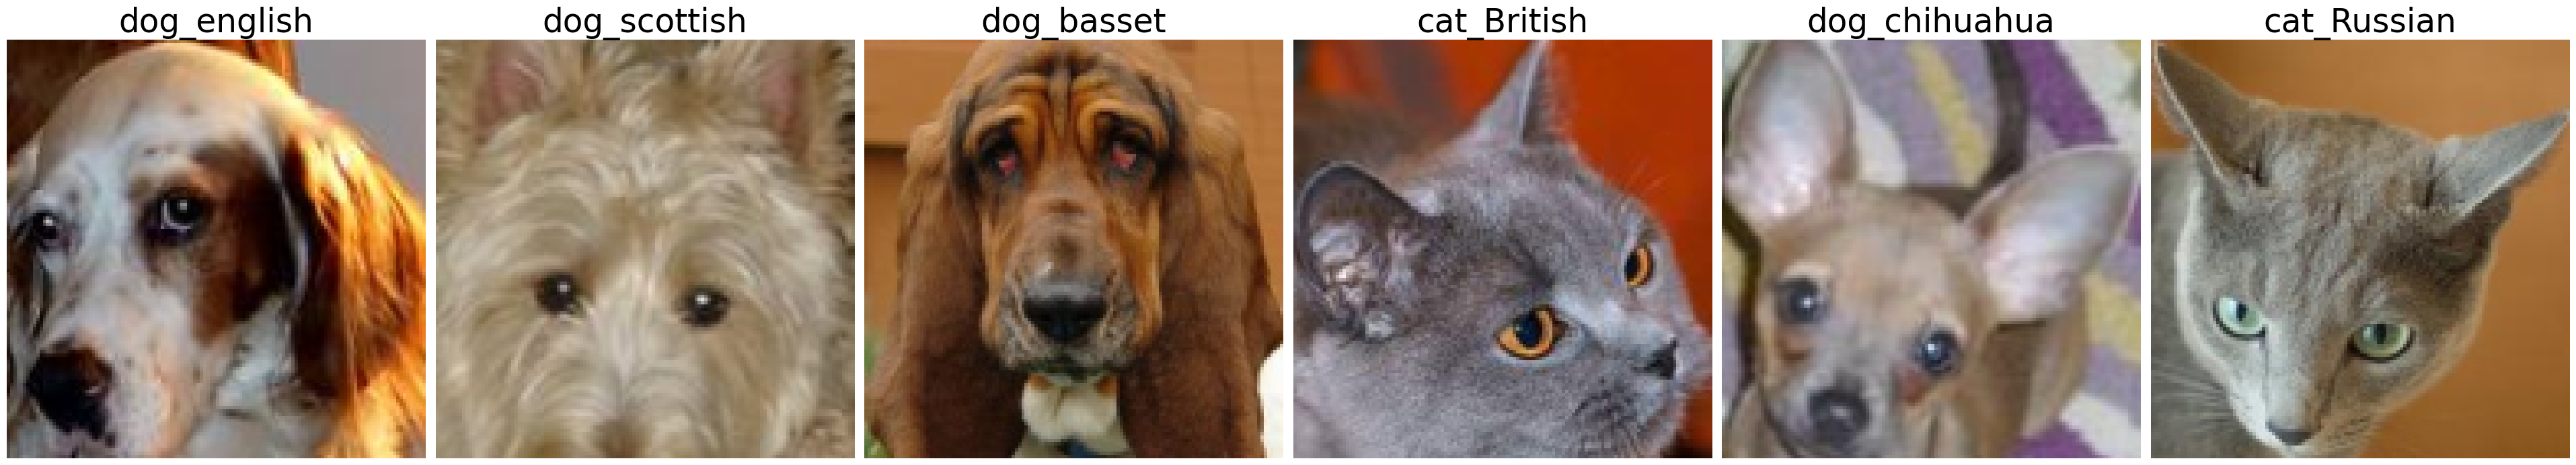

In [12]:
row_count = 3
columns_count = 6

for row_index, (tensor_data, labels_data) in zip(range(row_count), train_loader):
    permutations = tensor_data[:columns_count].permute(0,2,3,1)
    titles = [dataset.classes[x] for x in labels_data[:columns_count]]
    display_images(permutations, titles = titles, fontsize = 35)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device is {device}')

device is cuda


Определим модель

In [14]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16,(3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 32,(3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 64,(3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(12544, 2048),
    torch.nn.ReLU(),    
    torch.nn.Linear(2048, number_classes)
)

model = model.to(device)

Задаем гиперпараметры

In [15]:
learning_rate = 0.001
opt = torch.optim.Adam
loss_fn_standart = torch.nn.CrossEntropyLoss()
cur_epochs = 10

Обучение нейронной сети

In [16]:
def validate(net, dataloader, loss_fn = loss_fn_standart):
    net.eval()
    count,acc,loss = 0, 0, 0
    with torch.no_grad():
        for features,labels in dataloader:
            features_device = features.to(device)
            labels_device = labels.to(device)
            out = net(features_device)
            loss += loss_fn(out, labels_device) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels_device).sum()
            count += len(labels)
    return loss.item() / count, acc.item() / count


def train_epoch(net, dataloader, optimizer = opt, lr = learning_rate ,loss_fn = loss_fn_standart):
    optimizer = optimizer(net.parameters(), lr = lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        features_device = features.to(device)
        labels_device = labels.to(device)
        optimizer.zero_grad()
        out = net(features_device)
        loss = loss_fn(out, labels_device)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc += (predicted == labels_device).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count


def train(net, train_loader, test_loader, optimizer = opt, lr = learning_rate, epochs = cur_epochs, loss_fn = loss_fn_standart):
    res = { 'train_loss' : [],'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(net,train_loader, optimizer = optimizer, lr = lr, loss_fn=loss_fn)
        valid_loss, valid_acc = validate(net,test_loader,loss_fn=loss_fn)
        print(f"epoch {epoch + 1}: train loss={train_loss:.3f}, train accuracy={train_acc:.3f}, valid loss={valid_loss:.3f}, valid acc={valid_acc:.3f}")
        res['train_loss'].append(train_loss)
        res['valid_loss'].append(valid_loss)
        res['train_acc'].append(train_acc)
        res['valid_acc'].append(valid_acc)
    return res

In [17]:
hist = train(model, train_loader, test_loader, epochs = cur_epochs, optimizer = opt, lr = learning_rate, loss_fn = loss_fn_standart)

epoch 1: train loss=0.054, train accuracy=0.080, valid loss=0.054, valid acc=0.110
epoch 2: train loss=0.045, train accuracy=0.205, valid loss=0.051, valid acc=0.188
epoch 3: train loss=0.039, train accuracy=0.307, valid loss=0.044, valid acc=0.330
epoch 4: train loss=0.031, train accuracy=0.422, valid loss=0.037, valid acc=0.353
epoch 5: train loss=0.025, train accuracy=0.547, valid loss=0.039, valid acc=0.404
epoch 6: train loss=0.019, train accuracy=0.656, valid loss=0.037, valid acc=0.448
epoch 7: train loss=0.013, train accuracy=0.734, valid loss=0.037, valid acc=0.493
epoch 8: train loss=0.009, train accuracy=0.838, valid loss=0.041, valid acc=0.476
epoch 9: train loss=0.005, train accuracy=0.897, valid loss=0.050, valid acc=0.457
epoch 10: train loss=0.003, train accuracy=0.946, valid loss=0.066, valid acc=0.473


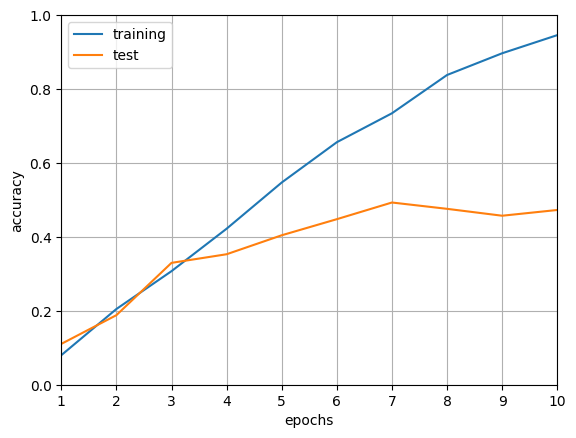

In [18]:
x_axis = range(1, cur_epochs + 1)
plt.plot(x_axis, hist['train_acc'], label='training')
plt.plot(x_axis, hist['valid_acc'], label='test')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim((1, cur_epochs))
plt.ylim((0, 1))
plt.legend()
plt.show()

confusion_matrix

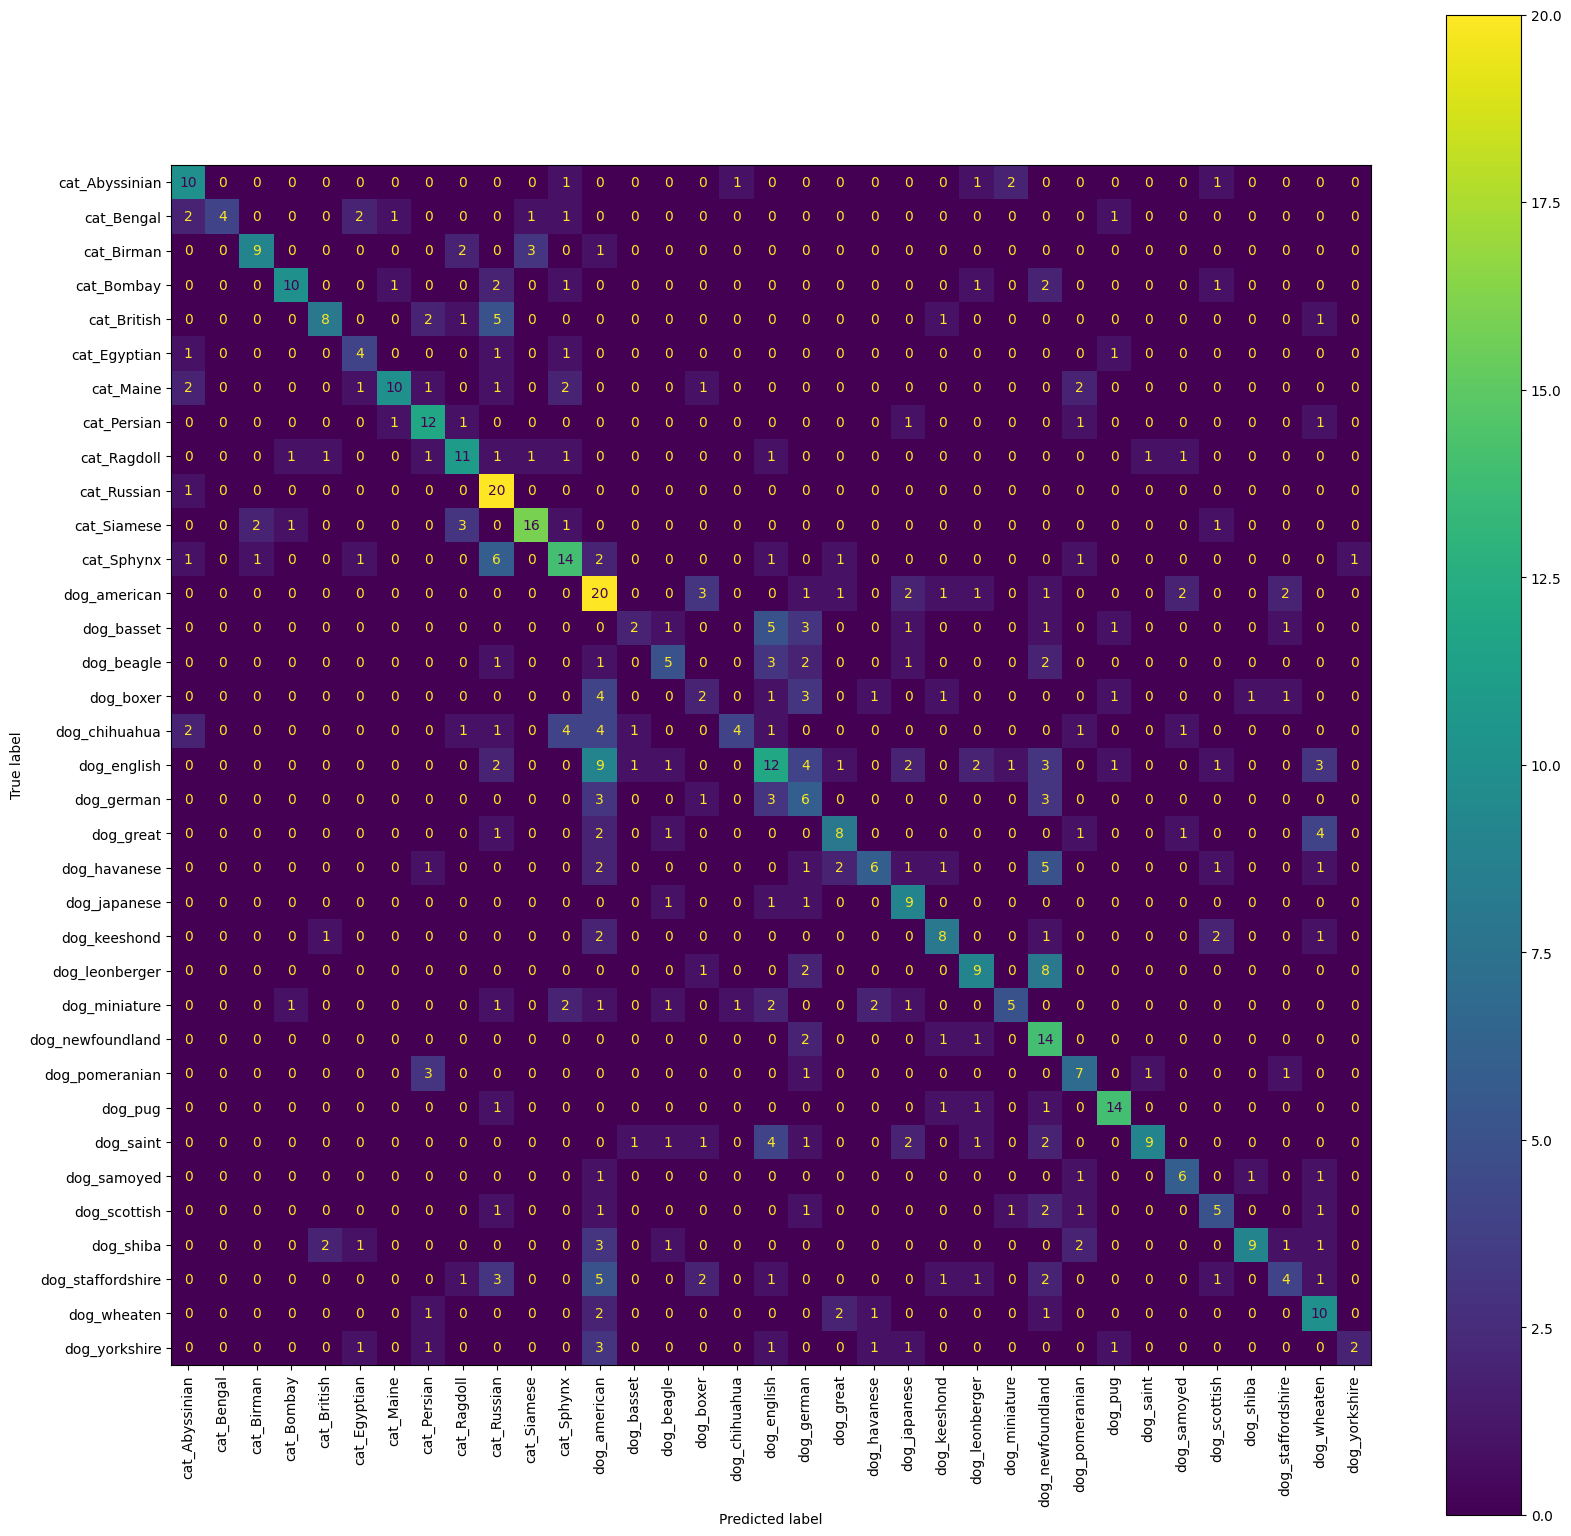

In [19]:
def show_confusion_matrix(net, test_loader):
    y_pred = []
    y_true = []
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        output = net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    classes = test_loader.dataset.dataset.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                            display_labels = classes)

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_axes([0, 0, 1.5, 1.5])

    disp.plot(ax = ax, xticks_rotation='vertical')
    plt.show()

show_confusion_matrix(model, test_loader)

Top-3 Accuracy

In [20]:
correct = 0
total = 0
for test, label in test_loader:
    out = model(test.to(device))
    _, r = out.topk(3, 1, True, True)
    r = r.t()
    correct += r.eq(label.to(device).view(1, -1).expand_as(r)).sum()
    total += len(label)
res = correct / total
print(res.item())

0.7185069918632507


<h2>Решение задачи кошки против собак</h2>

In [21]:
dataset = torchvision.datasets.ImageFolder(
    dataset_folder,
    transform = tr.Compose([
        tr.Resize(image_size),
        tr.CenterCrop(image_size),
        tr.ToTensor()
    ]),
    target_transform = tr.Lambda(lambda pet_class: torch.tensor(1) if pet_classes_names[pet_class].startswith('cat_') else torch.tensor(0))
)

len_dataset = len(dataset)
train_length = int(0.8 * len_dataset)
test_length = len_dataset - train_length
split_size = [train_length, test_length]

train_data, test_data = torch.utils.data.random_split(dataset, split_size)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

In [22]:
binary_model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 32, (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 64, (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(12544, 2048),
    torch.nn.ReLU(),    
    torch.nn.Linear(2048, 2)
)

binary_model = binary_model.to(device)

history = train(binary_model, train_loader, test_loader, epochs = cur_epochs, lr = learning_rate, loss_fn = loss_fn_standart)
     

epoch 1: train loss=0.011, train accuracy=0.637, valid loss=0.011, valid acc=0.628
epoch 2: train loss=0.008, train accuracy=0.738, valid loss=0.007, valid acc=0.816
epoch 3: train loss=0.006, train accuracy=0.824, valid loss=0.007, valid acc=0.834
epoch 4: train loss=0.006, train accuracy=0.827, valid loss=0.006, valid acc=0.840
epoch 5: train loss=0.005, train accuracy=0.863, valid loss=0.005, valid acc=0.865
epoch 6: train loss=0.004, train accuracy=0.885, valid loss=0.005, valid acc=0.851
epoch 7: train loss=0.004, train accuracy=0.911, valid loss=0.005, valid acc=0.857
epoch 8: train loss=0.003, train accuracy=0.922, valid loss=0.006, valid acc=0.880
epoch 9: train loss=0.003, train accuracy=0.939, valid loss=0.005, valid acc=0.886
epoch 10: train loss=0.002, train accuracy=0.940, valid loss=0.004, valid acc=0.908


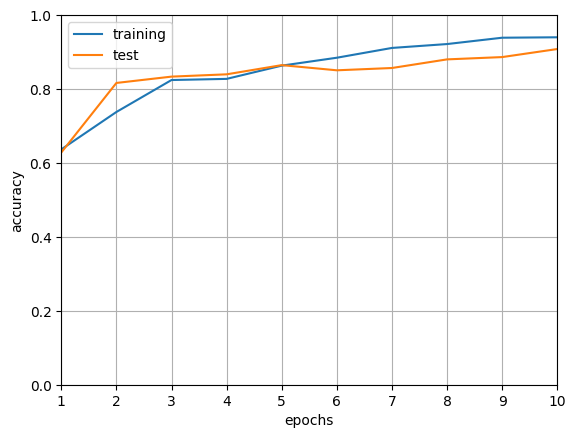

In [23]:
x_axis = range(1, cur_epochs + 1)
plt.plot(x_axis, history['train_acc'], label='training')
plt.plot(x_axis, history['valid_acc'], label='test')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim((1, cur_epochs))
plt.ylim((0, 1))
plt.legend()
plt.show()